In [1]:
# => makes the plot interactive
%matplotlib widget
# inline makes the plots static
#%matplotlib inline 
# NB: everything is done in pixels since the spectra are not wavelength-calibrated

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import warnings
# filter astropy warning on fits headers
warnings.filterwarnings('ignore', category=UserWarning, append=True)
from spectro_tools import *
import glob # helps with building file lists
from numpy.polynomial import chebyshev
import re
%load_ext autoreload
%autoreload 2

# Just like we did for image reduction, reducing spectra involves:
# 1 - generate master_bias = median(bias)
# 2 - generate master_flat = median(normalized (flat-master_bias))
# 3 - reduced_spectrum = (raw_spectrum - master_bias)/master_flat
# and we'll stop here, as:
# 4 - the last step is the wavelength calibration, and is done in a different notebook


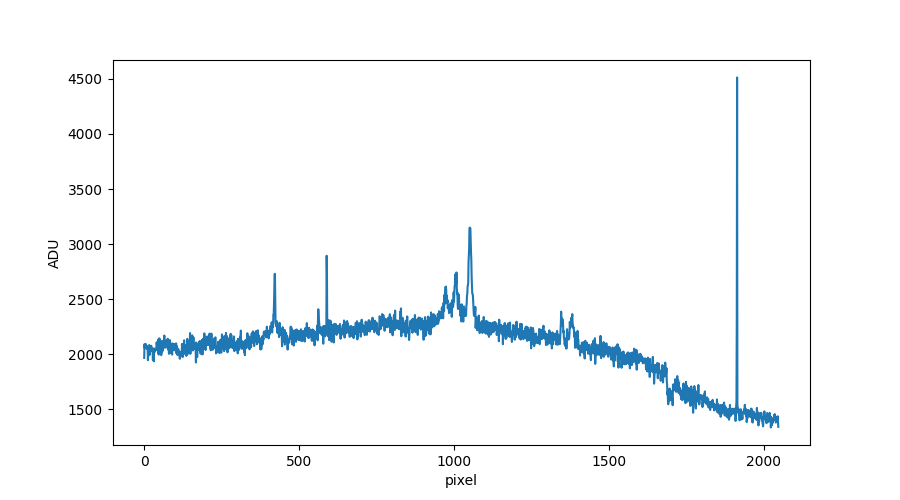

In [2]:
files=glob.glob('../../data/2024/M81/M81_3.fits')
xaxis,data=read_raw_spectrum(files[0])
plt.figure(figsize=(9, 5))
plt.plot(data)
plt.xlabel('pixel')
plt.ylabel('ADU')
plt.show()

[500.0, 1004.0, 2.0]
[0.000e+00 1.000e+00 2.000e+00 ... 2.045e+03 2.046e+03 2.047e+03]
[ 500. 1004.    2.  500.  974.    2.  500. 1050.    2. 2000.  100. 1000.]
[ 323.11068837 1006.76607116   11.30904239  254.25882064  972.72490101
    8.32976353  815.84835735 1051.61090434    5.8928331  2283.39462145
  904.77045957 1098.08358981]
Ha [ 323.11068837 1006.76607116   11.30904239]
Area 9159.40137300718
NII_blue [254.25882064 972.72490101   8.32976353]
Area 5308.827753308114
NII_red [ 815.84835735 1051.61090434    5.8928331 ]
Area 12051.01199393913


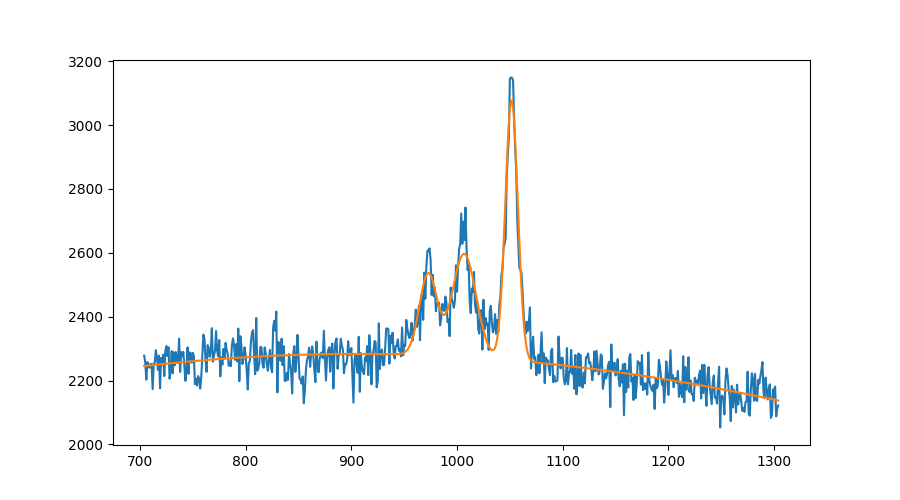

In [10]:
# try to fit the NII+Halpha system
# NOte coords are in pixels as spectrum is raw uncalibrated
ha_center=1004.
NII_blue_center=974.
NII_red_center=1050.
ha_guess=[500.,ha_center,2.]
NII_blue_guess=[500.,NII_blue_center,2.]
NII_red_guess=[500.,NII_red_center,2.]
bg_guess=[2000.,100.,1000.] # HERE BIG CHEAT: WE USE A VERY WIDE GAUSSIAN AS the background
print(ha_guess)
wavelengths=np.asarray(xaxis,dtype=np.float32)
#sigma=wavelengths*0.+1.e10
sigma=np.full(len(wavelengths),1.e10)
print(wavelengths)
ind=np.where((wavelengths>=ha_center-300.)&(wavelengths<=ha_center+300.))[0]
sigma[ind]=1.e-5
# fit the spectrum as a sum of gaussian lines using curve_fit and our first guess
full_guess=[]
full_guess=np.append(full_guess,ha_guess)
full_guess=np.append(full_guess,NII_blue_guess)
full_guess=np.append(full_guess,NII_red_guess)
full_guess=np.append(full_guess,bg_guess)
print(full_guess)
params, covariance = curve_fit(gaussian, wavelengths, data, p0=full_guess,sigma=sigma,method='dogbox')
print(params)
gau=gaussian(wavelengths, *params)

ha_params=params[0:3]
print('Ha',ha_params)
print('Area',ha_params[0]*ha_params[2]*np.sqrt(2.*np.pi))
NII_blue_params=params[3:6]
print('NII_blue',NII_blue_params)
print('Area',NII_blue_params[0]*NII_blue_params[2]*np.sqrt(2.*np.pi))
NII_red_params=params[6:9]
print('NII_red',NII_red_params)
print('Area',NII_red_params[0]*NII_red_params[2]*np.sqrt(2.*np.pi))

plt.figure(figsize=(9,5))
plt.plot(wavelengths[ind],data[ind])
plt.plot(wavelengths[ind],gau[ind])
plt.show()

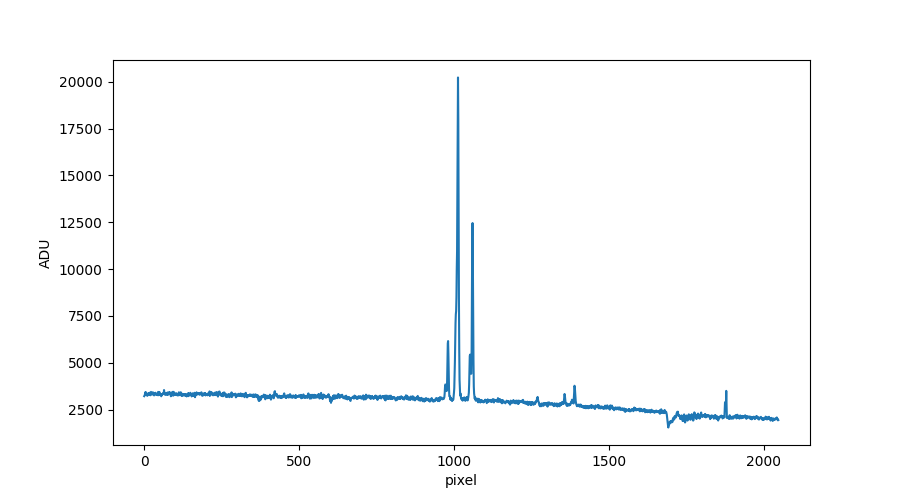

In [11]:
# ANOTHER EXAMPLE OF BLENDED LINES
files=glob.glob('../../data/2024/NGC_2392/NGC_2392_300s_3.fits')
xaxis,data=read_raw_spectrum(files[0])
plt.figure(figsize=(9, 5))
plt.plot(data)
plt.xlabel('pixel')
plt.ylabel('ADU')
plt.show()

[0.000e+00 1.000e+00 2.000e+00 ... 2.045e+03 2.046e+03 2.047e+03]
[3.00e+03 5.00e+02 9.72e+02 2.00e+00 5.00e+02 9.80e+02 2.00e+00]
[3.09139478e+03 7.82233658e+02 9.72846873e+02 2.04836917e+00
 3.14810016e+03 9.80674096e+02 1.77508246e+00]
NII_blue [782.23365806 972.84687333   2.04836917]
Area 4995.082337771084
NII_red [3.14810016e+03 9.80674096e+02 1.77508246e+00]
Area 14007.383129656351


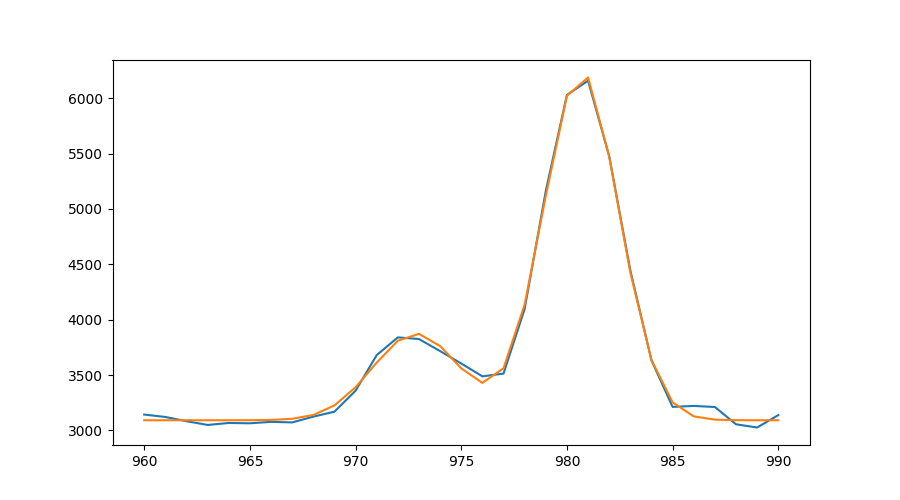

In [24]:
# try to fit double NII_6549 lines with gaussian_plus_bg (=> background is a constant)
# NOte coords are in pixels as spectrum is raw uncalibrated
NII_blue_center=972.
NII_red_center=980.
NII_blue_guess=[500.,NII_blue_center,2.]
NII_red_guess=[500.,NII_red_center,2.]
bg=[3000.]
wavelengths=np.asarray(xaxis,dtype=np.float32)
sigma=np.full(len(wavelengths),1.e10)
print(wavelengths)
ind=np.where((wavelengths>=960.)&(wavelengths<=990.))[0]
sigma[ind]=1.e-5
# fit the region as a sum of gaussian lines using curve_fit and our first guess
full_guess=[]
full_guess=np.append(full_guess,bg)
full_guess=np.append(full_guess,NII_blue_guess)
full_guess=np.append(full_guess,NII_red_guess)
print(full_guess)
params, covariance = curve_fit(gaussian_plus_bg, wavelengths, data, p0=full_guess,sigma=sigma)
print(params)
gau=gaussian_plus_bg(wavelengths, *params)

NII_blue_params=params[1:4]
print('NII_blue',NII_blue_params)
print('Area',NII_blue_params[1]*NII_blue_params[2]*np.sqrt(2.*np.pi))
NII_red_params=params[4:7]
print('NII_red',NII_red_params)
print('Area',NII_red_params[0]*NII_red_params[2]*np.sqrt(2.*np.pi))

plt.figure(figsize=(9,5))
plt.plot(wavelengths[ind],data[ind])
plt.plot(wavelengths[ind],gau[ind])
plt.show()